In [27]:
import numpy as np
import torch
import math
from torch import nn
import torch.nn.functional as F
from torch import distributions as pyd

from utils import util, buffer
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn.decomposition import NMF
from utils import util, buffer
import pickle
import h5py

In [8]:
import os
path = './figure/kms/spedersac/SPEDER_pure_feature_ctrl_f512_noise2/0'
assert os.path.exists(path)
for i in range(1,100):
    name = f'{path}/phi_{i}.png'
    if os.path.exists(name):
        os.remove(name)


In [6]:
normalize_dict = torch.load('./kms/normalize_dict.pth')
print(normalize_dict)

{'state_mean': array([157.51327254, 145.82275549, 157.97605809, 146.35762855,
       158.12154658, 146.96377525, 158.26535957, 147.49383795,
       158.57927232, 147.96390626, 158.59594927, 148.45956144,
       158.5771941 , 147.37293105, 157.69929714, 147.74750126]), 'state_std': array([277.84933837, 271.19691796, 279.22224104, 272.56254317,
       280.30159348, 273.86048222, 281.41436202, 275.14145518,
       282.7898248 , 276.55328642, 283.80230795, 277.83779288,
       282.10167612, 275.62863874, 281.58028575, 275.68537402]), 'action_mean': array([ 1.32896445e-03,  8.14934221e-03,  1.62640791e-03,  7.44792739e-03,
        8.81985202e-05,  7.30233888e-03, -5.65949423e-04,  4.46204165e-03,
       -1.05064886e-03,  3.59017573e-03, -2.20453129e-03,  2.76227989e-03,
       -2.56618231e-03,  6.80929291e-03, -4.28757420e-04,  5.09458114e-03]), 'action_std': array([1.44071589, 1.43505073, 1.43255235, 1.42586441, 1.41626531,
       1.40401298, 1.45514037, 1.44656813, 1.58294263, 1.57404859,

In [12]:
a = 32
b = 16
print(a == 2*b)
print(type(a), type(b))

True
<class 'int'> <class 'int'>


In [16]:
omega_list = torch.randn(16,128)
torch.save(omega_list, './kms/omega_list.pt')
# b_list = torch.FloatTensor(np.random.uniform(0, 2*np.pi, (8,1)))
b_list = torch.randn(1,128)
torch.save(b_list, './kms/b_list.pt')

In [17]:
def check_multiple_step_rollout(lr, syllable, replay_buffer):
    syllable_idx = np.where(replay_buffer.task == syllable)[0]
    transition = np.where(np.diff(syllable_idx) != 1)[0]+1
    print(len(transition))
    state_seqs = [None] * (len(transition)-1)
    for i in range(len(transition)-1):
        # print(transition[i], transition[i+1])
        # print(syllable_idx[transition[i]:transition[i+1]-1])
        state_seqs[i] = replay_buffer.state[syllable_idx[transition[i]:transition[i+1]-1]]
        assert state_seqs[i].shape[-1] == 16
    all_error = np.zeros(len(transition)-1)
    for i in range(len(state_seqs)):
        imitation_state_seq = np.zeros_like(state_seqs[i])
        # print(state_seqs[i], transition[i], syllable_idx[transition[i]:transition[i+1]-1])
        imitation_state_seq[0] = state_seqs[i][0]
        for j in range(1, state_seqs[i].shape[0]):
            imitation_state_seq[j] = lr.predict(imitation_state_seq[j-1].reshape(1, -1)).reshape(-1)
        error = np.mean(np.abs(imitation_state_seq - state_seqs[i]))
        # print(i, error)
        all_error[i] = error
    # print('all:', all_error.mean())
    return all_error.mean()

In [ ]:
from sklearn.linear_model import LinearRegression
from visualize import plot_gif
lr = LinearRegression()
replay_buffer_path = './kms/replay_buffer_filtered_allnormalized_augmented.pth'
replay_buffer_state_dict = torch.load(replay_buffer_path)
state_dim, action_dim = 16, 16
replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, max_size=10000)
replay_buffer.load_state_dict(replay_buffer_state_dict)
znormalized_state = replay_buffer_state_dict['state']
znormalized_action = replay_buffer_state_dict['action']
znormalized_next_state = replay_buffer_state_dict['next_state']
print(znormalized_state.shape, znormalized_next_state.shape)
sa_input = np.concatenate([znormalized_state, znormalized_action], axis=1)
# split train and test buffer
train_buffer_size = int(0.8 * len(znormalized_state))
print(train_buffer_size)
lr.fit(znormalized_state[:train_buffer_size], znormalized_next_state[:train_buffer_size])
new_next_state_pred = lr.predict(znormalized_state[train_buffer_size:])
error = np.abs(new_next_state_pred - znormalized_next_state[train_buffer_size:])
print(error.shape)
error_mean = np.mean(error, axis=0)
print(error_mean, error_mean.mean())

# syllable_error = np.zeros(10)
# for syllable in range(10):
#     syllable_error[syllable] = check_multiple_step_rollout(lr, syllable, replay_buffer)
#     print(syllable, syllable_error[syllable])
# print(syllable_error, syllable_error.mean())
# timestep = 30
# state_dim = action_dim = 16
# state_seqs = np.zeros((timestep, state_dim))
# for syllable in range(10):
#     all_idx = np.where(replay_buffer.task == syllable)[0]
#     pred_next_state = lr.predict(replay_buffer.state[all_idx])
#     error = np.abs(pred_next_state - replay_buffer.next_state[all_idx])
#     error_mean = np.mean(error, axis=0)
#     print(error_mean, error_mean.mean())
#     while True:
#         sample = replay_buffer.sample(256)
#         task = sample.task
#         # print(task)
#         all_idx = torch.where(task == syllable)[0]
#         if len(all_idx) > 0:
#             break
#     idx = all_idx[0]
#     state = sample.state[idx].detach().cpu().numpy()
#     state_seqs[0] = state
#     for i in range(1, timestep):
#         next_state = lr.predict(state.reshape(1, -1))
#         state_seqs[i] = next_state
#         state = next_state
#     plot_gif(state_seqs, f'./figure/kms/linear_state/{syllable}_notask.gif')

(962302, 16) (962302, 16)
769841
(192461, 16)
[0.00350089 0.00358518 0.00351423 0.00357442 0.00353849 0.00356602
 0.00361422 0.00364504 0.00403092 0.00409393 0.00512343 0.0052476
 0.00410801 0.00418009 0.00413372 0.00416732] 0.003976469887239306


In [ ]:
from sklearn.linear_model import LinearRegression
from visualize import plot_gif

replay_buffer_path = './kms/replay_buffer_filtered_allnormalized_augmented.pth'
replay_buffer_state_dict = torch.load(replay_buffer_path)
state_dim, action_dim = 16, 16
replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, max_size=10000)
replay_buffer.load_state_dict(replay_buffer_state_dict)
timestep = 30
state_dim = action_dim = 16
state_seqs = np.zeros((timestep, state_dim))
all_error = np.zeros((10,))
for syllable in range(10):
    lr = LinearRegression()
    all_idx = np.where(replay_buffer.task == syllable)[0]
    znormalized_state = replay_buffer.state[all_idx]
    znormalized_next_state = replay_buffer.next_state[all_idx]
    lr.fit(znormalized_state, znormalized_next_state)
    new_next_state_pred = lr.predict(znormalized_state)
    error = np.abs(new_next_state_pred - znormalized_next_state)
    print(error.shape)
    error_mean = np.mean(error, axis=0)
    print(error_mean, error_mean.mean())
    all_error[syllable] = check_multiple_step_rollout(lr, syllable, replay_buffer)
    print(syllable, all_error[syllable])
    # sample_idx = all_idx[np.random.randint(len(all_idx))]
    # state = replay_buffer.state[sample_idx]
    # state_seqs[0] = state
    # for i in range(1, timestep):
    #     next_state = lr.predict(state.reshape(1, -1))
    #     state_seqs[i] = next_state
    #     state = next_state
    # plot_gif(state_seqs, f'./figure/kms/linear_state/{syllable}task.gif')
print('all:', all_error.mean())

In [28]:
state_dim = 16
action_dim = 16
n_task = 10
replay_buffer_path = './kms/replay_buffer.pth'
replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, 10000)
replay_buffer.load_state_dict(torch.load(replay_buffer_path))
# action_all = replay_buffer.action
# syllable = 4
# syllable_idx = np.where(replay_buffer.task == syllable)[0]
# print(all_idx)
# transition = np.where(np.diff(syllable_idx) != 1)[0]+1
# print(len(transition))
# state_seqs = [None] * len(transition)
# for i in range(len(transition)-1):
    # print(transition[i], transition[i+1])
    # print(syllable_idx[transition[i]:transition[i+1]-1])
    # state_seqs[i] = replay_buffer.state[syllable_idx[transition[i]:transition[i+1]-1]]
    # assert state_seqs[i].shape[-1] == 16
# from visualize import plot_gif

# all_actions = replay_buffer.action[syllable_idx]

# resorted_idx = np.argsort(np.abs(all_actions[:, 1]))[-10:]
# print(np.sort(np.abs(all_actions[:, 1]))[-60:-50])
# abnormal_actions = all_actions[resorted_idx]
# print(abnormal_actions)
# print(resorted_idx)
# abnormal_state_idx = syllable_idx[resorted_idx]
# print(abnormal_state_idx)
# abnormal_state_seqs = [None] * len(abnormal_state_idx)

# for i in range(len(abnormal_state_idx)):
    # for j in range(len(transition)):
        # print(abnormal_state_idx[i], transition[j])
        # if abnormal_state_idx[i] < syllable_idx[transition[j]]:
            # abnormal_state_seqs[i] = replay_buffer.state[syllable_idx[transition[j-1]:transition[j]-1]]
            # break
# for i in range(len(abnormal_state_seqs)):
    # plot_gif(abnormal_state_seqs[i], './figure/kms/abnormal/abnormal_state_{}.gif'.format(i))

In [29]:
scale_factor = 200
action_all = replay_buffer.action
print(action_all.shape[0])
# syllable_indicator = (replay_buffer.task == 3).squeeze()
# print(len(np.where(all_idx)[0]))
filtered_replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, 10000)
size = replay_buffer.size
# filtered_replay_buffer.state = replay_buffer.state
# filtered_replay_buffer.next_state = replay_buffer.next_state
assert np.isclose(replay_buffer.state + replay_buffer.action, replay_buffer.next_state).all()
new_state = replay_buffer.state
new_next_state = replay_buffer.next_state

state_mean = np.mean(np.concatenate([new_state, new_next_state[-2:]], axis=0))
print(state_mean)
mildnormalized_state = (new_state - state_mean) / scale_factor
filtered_replay_buffer.state = mildnormalized_state

mildnormalized_next_state = (new_next_state - state_mean) / scale_factor
filtered_replay_buffer.next_state = mildnormalized_next_state

new_action = replay_buffer.action
mildnormalized_action = new_action / scale_factor
filtered_replay_buffer.action = mildnormalized_action

filtered_replay_buffer.reward = replay_buffer.reward
filtered_replay_buffer.done = replay_buffer.done
filtered_replay_buffer.task = replay_buffer.task
filtered_replay_buffer.next_task = replay_buffer.next_task
filtered_replay_buffer.size = replay_buffer.size
filtered_replay_buffer.ptr = 0

assert np.isclose(filtered_replay_buffer.state + filtered_replay_buffer.action, filtered_replay_buffer.next_state).all()
torch.save(filtered_replay_buffer.state_dict(), './kms/replay_buffer_mildnormalized200.pth')

481151
305.776227883854


In [15]:
action_all = replay_buffer.action
print(action_all.shape[0])
# syllable_indicator = (replay_buffer.task == 3).squeeze()
# print(len(np.where(all_idx)[0]))
filtered_replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, 10000)
size = replay_buffer.size
# filtered_replay_buffer.state = replay_buffer.state
# filtered_replay_buffer.next_state = replay_buffer.next_state
assert np.isclose(replay_buffer.state + replay_buffer.action, replay_buffer.next_state).all()
new_state = replay_buffer.state
new_next_state = replay_buffer.next_state
# print(new_state)
# print(np.mean(np.abs(new_state[1:] - new_next_state[:-1])))
# print(np.mean(np.abs(new_state - new_next_state)))
# print(np.mean(np.abs(new_next_state - new_state)/np.abs(new_state)))
state_mean = np.mean(np.concatenate([new_state, new_next_state[-2:]], axis=0), axis=0) # The last one item and its augmentation's next state
state_std = np.std(np.concatenate([new_state, new_next_state[-2:]], axis=0), axis=0)
znormalized_state = (new_state - state_mean) / state_std
filtered_replay_buffer.state = znormalized_state
znormalized_next_state = (new_next_state - state_mean) / state_std
filtered_replay_buffer.next_state = znormalized_next_state
# ##TODO: znormalize the state
# ##TODO: try the minmax normalization
# # 42499
filtered_replay_buffer.reward = replay_buffer.reward
filtered_replay_buffer.done = replay_buffer.done
filtered_replay_buffer.task = replay_buffer.task
filtered_replay_buffer.next_task = replay_buffer.next_task
new_action = replay_buffer.action
action_mean = np.mean(new_action, axis=0)
action_std = np.std(new_action, axis=0)
znormalized_action = (new_action - action_mean) / action_std
# idx = np.random.randint(0, len(znormalized_action))
# print(znormalized_action[idx])
# # noisy_action = np.random.normal(0, 1, znormalized_action.shape)
# # print(noisy_action[idx])
filtered_replay_buffer.action = znormalized_action
filtered_replay_buffer.size = replay_buffer.size
filtered_replay_buffer.ptr = 0
rescaled_state_back = znormalized_state * state_std + state_mean
rescaled_action_back = znormalized_action * action_std + action_mean
rescaled_next_state_back = znormalized_next_state * state_std + state_mean
assert np.isclose(rescaled_state_back+rescaled_action_back, rescaled_next_state_back).all()
# torch.save(filtered_replay_buffer.state_dict(), './kms/replay_buffer_filtered_allnormalized_augmented.pth')

962302


In [18]:
print(znormalized_next_state[0])
print(filtered_replay_buffer.next_state[0])

[0.97323601 0.73780305 0.93101172 0.75417447 0.88411386 0.76300443
 0.83036601 0.76479702 0.78985672 0.75919482 0.75880432 0.75390199
 0.79886911 0.80742939 0.80347764 0.73335926]
[0.97323601 0.73780305 0.93101172 0.75417447 0.88411386 0.76300443
 0.83036601 0.76479702 0.78985672 0.75919482 0.75880432 0.75390199
 0.79886911 0.80742939 0.80347764 0.73335926]


In [ ]:
normalize_dict = {'state_mean':state_mean, 'state_std':state_std, \
                  'action_mean': action_mean, 'action_std': action_std,
                  'state_min': np.min(np.concatenate([new_state, new_next_state[-1:]], axis=0), axis=0),
                  'state_max': np.max(np.concatenate([new_state, new_next_state[-1:]], axis=0), axis=0),
                  'action_min': np.min(new_action, axis=0),
                  'action_max': np.max(new_action, axis=0)}
torch.save(normalize_dict, './kms/normalize_dict.pth')

: 

In [8]:
replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, 10000)
replay_buffer.load_state_dict(torch.load('./kms/train_data_filtered_allnormalized_augmented.pth'))
np.set_printoptions(threshold=np.inf)
for i in range(100):
    batch = replay_buffer.sample(256)
    state = batch.state.cpu().numpy()
    action = batch.action.cpu().numpy()
    next_state = batch.next_state.cpu().numpy()
    rescaled_state = state * state_std + state_mean
    rescaled_action = action * action_std + action_mean
    rescaled_next_state = next_state * state_std + state_mean
    predict_next_state = rescaled_state + rescaled_action
    error = np.abs(rescaled_next_state - predict_next_state)
    print(error.mean())
    try: assert np.isclose(rescaled_next_state, predict_next_state, atol=1e-5).all()
    except: 
        print(error)
        break

3.11028498526625e-06
3.077762023457697e-06
2.762009023420369e-06
2.9261336829332455e-06
3.086864873860589e-06
2.8291463505537016e-06
[[3.58113539e-12 2.97482404e-06 6.82121026e-13 2.51361598e-10
  1.05118571e-06 3.25258043e-10 5.50727208e-07 8.18545232e-11
  8.52651283e-14 3.33961339e-06 4.93624316e-06 4.57021088e-11
  6.83514202e-07 3.61694674e-10 3.54818170e-06 1.27367157e-05]
 [1.71126769e-05 1.17224367e-05 1.08373535e-05 2.67035654e-06
  1.30953449e-05 3.15767466e-07 1.35855771e-11 8.18545232e-11
  9.35237514e-06 3.22830044e-06 7.41806616e-12 4.57021088e-11
  1.56936704e-06 9.76848958e-06 6.11066753e-12 9.27684596e-11]
 [3.58113539e-12 2.89162472e-10 6.92077771e-06 6.41892069e-06
  1.59161573e-12 3.25258043e-10 2.25739595e-05 1.13302347e-05
  4.26903188e-06 1.98001774e-05 2.69485170e-05 1.21461276e-05
  1.47846058e-05 1.65837026e-05 2.88992601e-06 1.38147971e-05]
 [2.19072945e-05 1.80386361e-05 6.82121026e-13 2.51361598e-10
  1.59161573e-12 3.25258043e-10 2.36361460e-05 8.34330149e

In [22]:
# print(znormalized_action[:100])

In [30]:
state_dim = 16
action_dim = 16
n_task = 10
replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, 10000)
replay_buffer.load_state_dict(torch.load('./kms/replay_buffer_mildnormalized200.pth'))
replay_buffer.next_state = replay_buffer.next_state
idx = np.arange(replay_buffer.size)
np.random.shuffle(idx)
train_idx = idx[:int(replay_buffer.size * 0.8)]
test_idx = idx[int(replay_buffer.size * 0.8):]
train_data = {}
test_data = {}
key = ['state', 'action', 'next_state', 'reward', 'done', 'task', 'next_task']
for k in key:
    train_data[k] = replay_buffer.__getattribute__(k)[train_idx]
    test_data[k] = replay_buffer.__getattribute__(k)[test_idx]
train_data['size'] = len(train_idx)
test_data['size'] = len(test_idx)
train_data['ptr'] = 0
test_data['ptr'] = 0
# rescale_train_state = train_data['state'] * state_std + state_mean
# rescale_train_action = train_data['action'] * action_std + action_mean
# rescale_train_next_state = train_data['next_state'] * state_std + state_mean
# assert np.isclose(rescale_train_state + rescale_train_action, rescale_train_next_state).all()
# rescale_test_state = test_data['state'] * state_std + state_mean
# rescale_test_action = test_data['action'] * action_std + action_mean
# rescale_test_next_state = test_data['next_state'] * state_std + state_mean
# assert np.isclose(rescale_test_state + rescale_test_action, rescale_test_next_state).all()
# assert np.isclose(train_data['state'] + train_data['action'], train_data['next_state']).all()
# assert np.isclose(test_data['state'] + test_data['action'], test_data['next_state']).all()
torch.save(train_data, './kms/train_data.pth')
torch.save(test_data, './kms/test_data.pth')
print(len(train_idx), len(test_idx))

384920 96231


In [6]:
normalize_dict = torch.load('./kms/normalize_dict_allnormalized_augment.pth')
state_mean = normalize_dict['state_mean']
state_std = normalize_dict['state_std']
action_mean = normalize_dict['action_mean']
action_std = normalize_dict['action_std']
train_buffer = buffer.ReplayBuffer(state_dim, action_dim, 10000)
train_buffer.load_state_dict(torch.load('./kms/train_data_filtered_augmented.pth'))
state = train_buffer.state
action = train_buffer.action
next_state = train_buffer.next_state
rescaled_state = state * state_std + state_mean
rescaled_action = action * action_std + action_mean
rescaled_next_state = next_state * state_std + state_mean
predict_next_state = rescaled_state + rescaled_action
error = np.abs(rescaled_next_state - predict_next_state)
print(error.mean())

7.056379497463337e-15


In [2]:
dlc_sample = pickle.load(open('./kms/dlc_sample.pkl', 'rb'))
print(dlc_sample.keys())
print(dlc_sample['coordinates'].keys())  

dict_keys(['coordinates', 'bodyparts'])
dict_keys(['22_04_26_cage4_0.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000', '21_12_2_def6b_2.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000', '21_12_10_def6a_3.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000', '21_12_10_def6a_1_1.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000', '22_04_26_cage4_1_1.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000', '21_12_2_def6a_1.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000', '21_12_10_def6b_3.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000', '22_04_26_cage4_0_2.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000', '21_11_8_one_mouse.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000', '22_27_04_cage4_mouse2_0.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000'])


In [4]:
state_dim = 18
action_dim = 18
n_task = 20
replay_buffer_path = './kms/replay_buffer.pth'
replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, 10000)
replay_buffer.load_state_dict(torch.load(replay_buffer_path))


In [5]:
print(action_all.shape)
print(action_all.max(), action_all.min())
print(action_all.mean(), action_all.std())
idx = np.argsort(np.abs(action_all[:,0]), axis=0)[-100:]
print(idx)
print(action_all[idx, 0])
print(action_all[idx, 1])
# plt.hist(action_all[:,0], bins=100)
# plt.plot(np.log(count))

NameError: name 'action_all' is not defined

In [6]:
action_normalized = (action_all - action_all.mean(axis=0)) / action_all.std(axis=0)
plt.hist(action_normalized[:,0], bins=10)
plt.show()
plt.close()
action_tanh = np.tanh(action_normalized)
plt.hist(action_tanh[:,0], bins=10)
plt.show()
plt.close()
print(action_all[-100:, 0])
print(action_normalized[-100:, 0])
print(action_tanh[-100:, 0])

NameError: name 'action_all' is not defined

In [7]:
state_dim = 18
action_dim = 18
n_task = 20
replay_buffer_path = './kms/replay_buffer.pth'
replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, 10000)
replay_buffer.load_state_dict(torch.load(replay_buffer_path))
action_all = replay_buffer.action
# action_min = action_all.min(0)
# action_max = action_all.max(0)
action_normalized = (action_all - action_all.mean(axis=0)) / action_all.std(axis=0)
normalize_dict = {'action_mean': action_all.mean(axis=0), 'action_std': action_all.std(axis=0)}
torch.save(normalize_dict, './kms/normalize_dict_znormalized.pth')
torch.save(replay_buffer.state_dict(), './kms/replay_buffer_znormalized.pth')
syllable = 2
syllable_idx = np.where(replay_buffer.task == syllable)[0]
np.random.shuffle(syllable_idx)
length = len(syllable_idx)
train_idx = syllable_idx[:int(length * 0.8)]
test_idx = syllable_idx[int(length * 0.8):]
key = ['state', 'next_state', 'reward', 'done', 'task', 'next_task']
train_data = {}
test_data = {}
for k in key:
    print(k)
    train_data[k] = replay_buffer.__getattribute__(k)[train_idx]
    test_data[k] = replay_buffer.__getattribute__(k)[test_idx]
train_data['action'] = action_normalized[train_idx]
test_data['action'] = action_normalized[test_idx]
train_data['size'] = len(train_idx)
test_data['size'] = len(test_idx)
train_data['ptr'] = 0
test_data['ptr'] = 0
torch.save(train_data, './kms/train_data_znormalized_action.pth')
torch.save(test_data, './kms/test_data_znormalized_action.pth')
print(len(train_idx), len(test_idx))


state
next_state
reward
done
task
next_task
67657 16915


In [32]:
from utils.util import unpack_batch
replay_buffer_path = './kms/train_data_znormalized_action.pth'
replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, 10000)
replay_buffer.load_state_dict(torch.load(replay_buffer_path))
state, action, next_state, reward, done, task, next_task = unpack_batch(replay_buffer.sample(100))
print(action[:100])

tensor([[ 1.3730e-04, -1.9323e-04,  5.5264e-04,  ..., -6.5699e-04,
          6.1359e-04, -9.1563e-04],
        [ 1.3730e-04, -1.9323e-04,  5.5264e-04,  ..., -6.5699e-04,
          6.6849e-01, -9.1563e-04],
        [ 1.3730e-04, -1.9323e-04,  5.5264e-04,  ..., -6.5699e-04,
          6.1359e-04, -9.0680e-01],
        ...,
        [ 1.3730e-04,  3.3793e-01,  6.4181e-01,  ..., -6.5699e-04,
          6.1359e-04, -9.1563e-04],
        [ 1.3730e-04, -1.9323e-04,  5.5264e-04,  ...,  7.8769e-01,
          6.1359e-04,  9.0497e-01],
        [-1.6073e-01, -1.9323e-04,  5.5264e-04,  ...,  7.8769e-01,
          6.6849e-01,  1.8109e+00]], device='cuda:0')


In [2]:
state_dim = 18
action_dim = 18
n_task = 20
train_buffer_path = './kms/train_buffer_state_dict.pth'
test_buffer_path = './kms/test_buffer_state_dict.pth'
train_buffer = buffer.ReplayBuffer(state_dim, action_dim, 100000)
test_buffer = buffer.ReplayBuffer(state_dim, action_dim, 100000)
train_buffer.load_state_dict(torch.load(train_buffer_path))
test_buffer.load_state_dict(torch.load(test_buffer_path))
syllable = 2
idx = np.where(train_buffer.task == syllable)[0]
print(idx)
single_task_buffer_train = buffer.ReplayBuffer(state_dim, action_dim, 100000)
single_task_buffer_train.state = train_buffer.state[idx]
print(single_task_buffer_train.state.shape)
single_task_buffer_train.action = train_buffer.action[idx]
single_task_buffer_train.reward = train_buffer.reward[idx]
single_task_buffer_train.next_state = train_buffer.next_state[idx]
single_task_buffer_train.done = train_buffer.done[idx]
single_task_buffer_train.task = train_buffer.task[idx]
single_task_buffer_train.next_task = train_buffer.next_task[idx]
single_task_buffer_train.size = len(idx)
single_task_buffer_test = buffer.ReplayBuffer(state_dim, action_dim, 100000)
idx = np.where(test_buffer.task == syllable)[0]
print(idx)
single_task_buffer_test.state = test_buffer.state[idx]
single_task_buffer_test.action = test_buffer.action[idx]
single_task_buffer_test.reward = test_buffer.reward[idx]
single_task_buffer_test.next_state = test_buffer.next_state[idx]
single_task_buffer_test.done = test_buffer.done[idx]
single_task_buffer_test.task = test_buffer.task[idx]
single_task_buffer_test.next_task = test_buffer.next_task[idx]
single_task_buffer_test.size = len(idx)
torch.save(single_task_buffer_train.state_dict(), './kms/single_task_buffer_train_state_dict.pth')
torch.save(single_task_buffer_test.state_dict(), './kms/single_task_buffer_test_state_dict.pth')
print(single_task_buffer_train.size)
print(single_task_buffer_test.size)


[    23     66     78 ... 477981 478000 478008]
torch.Size([34165, 18])
[     1      9     16 ... 119494 119502 119512]
34165
8554


34165
8554


In [17]:
state_dim = 54
action_dim = 54
n_task = 60
original_replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, 100000, 'cpu')
replay_buffer_path = f'./data/replay_buffer_18body_task.pth'
original_replay_buffer.load_state_dict(torch.load(replay_buffer_path))
length = original_replay_buffer.size
state_min = original_replay_buffer.state[:length].min(0)
state_max = original_replay_buffer.state[:length].max(0)
action_min = original_replay_buffer.action[:length].min(0)
action_max = original_replay_buffer.action[:length].max(0)
next_state_min = original_replay_buffer.next_state[:length].min(0)
next_state_max = original_replay_buffer.next_state[:length].max(0)
print(state_min, state_max, action_min, action_max)
normalize_dict = {
    'state_min': state_min,
    'state_max': state_max,
    'action_min': action_min,
    'action_max': action_max,
    'next_state_min': next_state_min,
    'next_state_max': next_state_max
}
print(state_min.shape)
torch.save(normalize_dict, f'./data/normalize_dict_18body_task.pth')

[-2.81414124e+02 -2.67535706e+02 -2.30321373e-01 -2.72488285e+02
 -2.65578430e+02  1.13103800e+01 -2.76488190e+02 -2.66397186e+02
  1.61228237e+01 -2.64006927e+02 -2.37520523e+02  5.36810074e+01
 -2.58135132e+02 -2.38814667e+02  6.97525330e+01 -2.70338968e+02
 -2.46600372e+02  3.92869797e+01 -2.70920837e+02 -2.54657990e+02
  1.94669628e+01 -2.65404297e+02 -2.49877762e+02  7.01666355e+00
 -2.67190002e+02 -2.61613922e+02 -3.81297135e+00 -2.71898956e+02
 -2.65631714e+02  2.84689504e+00 -2.62173462e+02 -2.48069580e+02
  3.87809105e+01 -2.74119804e+02 -2.48202652e+02  3.56290741e+01
 -2.89900787e+02 -2.59672089e+02 -2.47821093e+00 -2.84619763e+02
 -2.67121704e+02 -6.21657372e+00 -2.78253601e+02 -2.49190475e+02
  6.38715033e+00 -2.62240967e+02 -2.51999039e+02  2.58186398e+01
 -2.53279934e+02 -2.45786713e+02  2.99162525e+00 -2.68810958e+02
 -2.45219397e+02 -3.85860051e+00] [298.31661987 302.06442261 289.2272644  294.58779907 299.20516968
 273.92251587 296.7043457  300.33581543 276.7713623  28

In [19]:
normalized_replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, 100000, 'cpu')
normalized_replay_buffer_path = f'./data/replay_buffer_18body_normalized_new.pth'
normalized_replay_buffer.load_state_dict(torch.load(normalized_replay_buffer_path))
normalize_dict = torch.load(f'./data/normalize_dict_18body_task.pth')
# print(normalized_replay_buffer.state.min(0)[0], normalized_replay_buffer.state.max(0)[0], normalized_replay_buffer.action.min(0)[0], normalized_replay_buffer.action.max(0)[0])
state_min, state_max, action_min, action_max = normalize_dict['state_min'], normalize_dict['state_max'], normalize_dict['action_min'], normalize_dict['action_max']
for i in range(100):
    state, action, next_state, reward, done, task, next_task = util.unpack_batch(normalized_replay_buffer.sample(1000))

    origin_state = (state+1)/2 * (state_max - state_min) + state_min
    origin_action = (action+1)/2 * (action_max - action_min) + action_min
    origin_next_state = (next_state+1)/2 * (next_state_max - next_state_min) + next_state_min
    next_state_predict = origin_state + origin_action
    # print(next_state_predict, origin_next_state)
    print(torch.abs(next_state_predict - origin_next_state).mean())

tensor(6.8188e-06, dtype=torch.float64)
tensor(6.8455e-06, dtype=torch.float64)
tensor(6.7853e-06, dtype=torch.float64)
tensor(6.7943e-06, dtype=torch.float64)
tensor(6.8842e-06, dtype=torch.float64)
tensor(6.9098e-06, dtype=torch.float64)
tensor(6.8192e-06, dtype=torch.float64)
tensor(6.7850e-06, dtype=torch.float64)
tensor(6.8259e-06, dtype=torch.float64)
tensor(6.9066e-06, dtype=torch.float64)
tensor(6.8256e-06, dtype=torch.float64)
tensor(6.8789e-06, dtype=torch.float64)
tensor(6.8480e-06, dtype=torch.float64)
tensor(6.7589e-06, dtype=torch.float64)
tensor(6.7546e-06, dtype=torch.float64)
tensor(6.7618e-06, dtype=torch.float64)
tensor(6.8122e-06, dtype=torch.float64)
tensor(6.9130e-06, dtype=torch.float64)
tensor(6.8966e-06, dtype=torch.float64)
tensor(6.7998e-06, dtype=torch.float64)
tensor(6.7808e-06, dtype=torch.float64)
tensor(6.8684e-06, dtype=torch.float64)
tensor(6.8485e-06, dtype=torch.float64)
tensor(6.7949e-06, dtype=torch.float64)
tensor(6.8010e-06, dtype=torch.float64)


: 

In [8]:
dlc_sample = pickle.load(open('./kms/dlc_sample.pkl', 'rb'))
print(dlc_sample.keys())
print(dlc_sample['coordinates'].keys())
print(dlc_sample['coordinates']['22_04_26_cage4_0.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000'].shape)

dict_keys(['coordinates', 'bodyparts'])
dict_keys(['22_04_26_cage4_0.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000', '21_12_2_def6b_2.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000', '21_12_10_def6a_3.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000', '21_12_10_def6a_1_1.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000', '22_04_26_cage4_1_1.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000', '21_12_2_def6a_1.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000', '21_12_10_def6b_3.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000', '22_04_26_cage4_0_2.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000', '21_11_8_one_mouse.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000', '22_27_04_cage4_mouse2_0.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000'])
(53623, 9, 2)


In [9]:
results = h5py.File('./kms/results.h5', 'r')
print(np.array(results['22_04_26_cage4_0.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000']['syllable']))

[14 14 14 ...  3  3  3]


In [10]:
syllables = {k:v['syllable'] for k,v in results.items()}
print(syllables)

{'21_11_8_one_mouse.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000': <HDF5 dataset "syllable": shape (71524,), type "<i8">, '21_12_10_def6a_1_1.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000': <HDF5 dataset "syllable": shape (53512,), type "<i8">, '21_12_10_def6a_3.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000': <HDF5 dataset "syllable": shape (35818,), type "<i8">, '21_12_10_def6b_3.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000': <HDF5 dataset "syllable": shape (53527,), type "<i8">, '21_12_2_def6a_1.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000': <HDF5 dataset "syllable": shape (107507,), type "<i8">, '21_12_2_def6b_2.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000': <HDF5 dataset "syllable": shape (107520,), type "<i8">, '22_04_26_cage4_0.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000': <HDF5 dataset "syllable": shape (53623,), type "<i8">, '22_04_26_cage4_0_2.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000': <HDF5 dataset "syllable":

This proves that the states are sorted by instance frequency

In [5]:
# stateseqs = {
#         'name1': np.array([1, 1, 2, 2, 2, 3]),
#         'name2': np.array([0, 0, 0, 1])}
stateseq_flat = np.hstack(list(syllables.values()))
state_onsets = np.pad(np.diff(stateseq_flat).nonzero()[0] + 1, (1, 0))
stateseq_flat = stateseq_flat[state_onsets]
counts = np.bincount(stateseq_flat, minlength=77)
print(counts[:25])
print(np.all(np.diff(counts)<=0))


[6135 3715 3226 3165 2824 2584 2295 2043 1845  853  681  500  458  420
  329  328  294  212  204  181  134  122  117   82   72]
True


In [6]:
def rotate(state, action, next_state, reward, done, task, next_task):
    theta = np.random.uniform(0, 2*np.pi)
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    assert state.shape == (16, )
    assert action.shape == (16, )
    assert next_state.shape == (16, )
    assert np.isclose(state + action, next_state).all()
    new_state = (state.reshape(-1,2) @ rotation_matrix).reshape(-1)
    new_next_state = (next_state.reshape(-1,2) @ rotation_matrix).reshape(-1)
    new_action = (action.reshape(-1,2) @ rotation_matrix).reshape(-1)
    assert np.isclose(new_state + new_action, new_next_state).all()
    return new_state, new_action, new_next_state, reward, done, task, next_task
def shift(state, action, next_state, reward, done, task, next_task):
    shift = np.random.randn(2)
    # print('shift:', shift)
    assert state.shape == (16, )
    assert action.shape == (16, )
    assert next_state.shape == (16, )
    assert np.isclose(state + action, next_state).all()
    new_state = (state.reshape(-1,2) + shift).reshape(-1)
    new_next_state = (next_state.reshape(-1,2) + shift).reshape(-1)
    new_action = action
    # print('state:', state, new_state)
    # print('action:', action, new_action)
    # print('next_state:', next_state, new_next_state)
    # print('compare:', new_state + new_action, new_next_state)
    assert np.isclose(new_state + new_action, new_next_state).all()
    return new_state, new_action, new_next_state, reward, done, task, next_task
    

In [ ]:
bodyparts=[
    'tail', 'spine4', 'spine3', 'spine2', 'spine1',
    'head', 'nose', 'right ear', 'left ear']
use_bodyparts=[
        'spine4', 'spine3', 'spine2', 'spine1',
        'head', 'nose', 'right ear', 'left ear']
use_bodyparts_idx = [bodyparts.index(bp) for bp in use_bodyparts]
state_dim = len(use_bodyparts) * 2
action_dim = len(use_bodyparts) * 2
n_task = 10 # filter out some non-frsequent tasks
extra_augmentation_step = 1
original_replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, 1000000, 'cpu')
for name in dlc_sample['coordinates'].keys():
    print(name)
    for i in range(len(dlc_sample['coordinates'][name])-1):
        state = np.array(dlc_sample['coordinates'][name][i][use_bodyparts_idx].flatten())
        next_state = np.array(dlc_sample['coordinates'][name][i+1][use_bodyparts_idx].flatten())
        action = next_state - state
        task = np.array(results[name]['syllable'][i])
        next_task = np.array(results[name]['syllable'][i+1])
        assert not np.all(np.isnan(state))
        if task < n_task and next_task < n_task and np.all(np.abs(action) <= 10):
            original_replay_buffer.add(state, action, next_state, 0, 0, task, next_task)
            # for j in range(extra_augmentation_step):
            #     an_item = shift(*rotate(state, action, next_state, 0, 0, task, next_task))
            #     assert np.isclose(an_item[0] + an_item[1], an_item[2]).all()
            #     original_replay_buffer.add(*an_item)
print(original_replay_buffer.size)



22_04_26_cage4_0.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000
21_12_2_def6b_2.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000
21_12_10_def6a_3.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000
21_12_10_def6a_1_1.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000
22_04_26_cage4_1_1.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000
21_12_2_def6a_1.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000
21_12_10_def6b_3.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000
22_04_26_cage4_0_2.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000
21_11_8_one_mouse.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000
22_27_04_cage4_mouse2_0.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000
481151


AttributeError: 'numpy.ndarray' object has no attribute 'unique'

In [12]:
print(np.unique(original_replay_buffer.action, return_counts=True))
torch.save(original_replay_buffer.state_dict(), './kms/replay_buffer.pth')

(array([-10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.,   6.,   8.,  10.]), array([    1588,     7672,    42923,   190446,  1099134, 13276608,
        1144496,   193740,    36643,     5481,     1269]))


In [7]:
length = original_replay_buffer.size
print(original_replay_buffer.state[:10000])

[[420. 340. 420. ... 380. 378. 364.]
 [420. 340. 420. ... 380. 378. 364.]
 [420. 340. 420. ... 380. 378. 364.]
 ...
 [208. 216. 232. ... 190. 268. 210.]
 [264. 240. 312. ... 322. 338. 338.]
 [264. 242. 314. ... 322. 340. 338.]]


This normalization scales every dimension with the same factor to make sure that the relative position is not discarded

In [ ]:
# normalize
all_state = original_replay_buffer.state[:length]
all_next_state = original_replay_buffer.next_state[:length]
state_min = np.concatenate([all_state, all_next_state[-1:]]).min()
state_max = np.concatenate([all_state, all_next_state[-1:]]).max()
state_range = state_max - state_min
normalized_state = (all_state - state_min) / state_range * 2 - 1
normalized_next_state = (all_next_state - state_min) / state_range * 2 - 1
# print(normalized_next_state.min(0), normalized_next_state.max(0))
all_action = original_replay_buffer.action[:length]
action_min = all_action.min()
action_max = all_action.max()
action_range = action_max - action_min
normalized_action = (all_action - action_min) / action_range * 2 - 1
# for i in range(state_dim):
#     print(all_action[:100,i])
#     plt.hist(all_action[:, i], bins=100)
#     plt.show()
for i in range(200):
    print(all_action[i].max(), end=' ')
####ACTION

0.0 0.0 0.0 0.0 0.0 2.0 2.0 2.0 0.0 2.0 2.0 0.0 2.0 4.0 2.0 2.0 2.0 0.0 0.0 2.0 2.0 0.0 2.0 0.0 0.0 0.0 2.0 0.0 0.0 2.0 4.0 0.0 2.0 2.0 0.0 2.0 0.0 4.0 2.0 0.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 8.0 2.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 0.0 2.0 0.0 2.0 0.0 0.0 0.0 0.0 2.0 2.0 0.0 2.0 0.0 2.0 2.0 2.0 2.0 2.0 2.0 0.0 0.0 2.0 2.0 2.0 2.0 0.0 2.0 2.0 2.0 0.0 2.0 0.0 0.0 2.0 0.0 0.0 0.0 2.0 0.0 0.0 2.0 2.0 2.0 0.0 0.0 2.0 2.0 0.0 0.0 0.0 2.0 2.0 0.0 2.0 0.0 0.0 2.0 0.0 0.0 2.0 2.0 0.0 0.0 0.0 2.0 0.0 2.0 0.0 2.0 0.0 2.0 2.0 0.0 2.0 0.0 0.0 2.0 0.0 0.0 0.0 0.0 2.0 2.0 0.0 0.0 0.0 0.0 2.0 2.0 0.0 0.0 0.0 2.0 0.0 0.0 2.0 2.0 0.0 0.0 2.0 2.0 0.0 0.0 2.0 2.0 2.0 2.0 2.0 4.0 2.0 2.0 2.0 2.0 2.0 0.0 2.0 2.0 2.0 2.0 0.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 

In [13]:
shuffle_idx = np.arange(length)
np.random.shuffle(shuffle_idx)
train_idx = shuffle_idx[:int(length*0.8)]
test_idx = shuffle_idx[int(length*0.8):]
train_state = torch.FloatTensor(normalized_state[train_idx])
train_action = torch.FloatTensor(normalized_action[train_idx])
train_next_state = torch.FloatTensor(normalized_next_state[train_idx])
train_task = torch.Tensor(original_replay_buffer.task[train_idx])
train_next_task = torch.Tensor(original_replay_buffer.next_task[train_idx])
train_reward = torch.zeros((train_state.shape[0], 1))
train_done = torch.zeros((train_state.shape[0], 1))
train_buffer_state_dict = {'state': train_state, 
                           'action': train_action, 
                           'next_state': train_next_state, 
                           'reward': train_reward, 
                           'done': train_done, 
                           'task': train_task, 
                           'next_task': train_next_task,
                           'size': len(train_idx),
                           'ptr': 0}
test_state = torch.FloatTensor(normalized_state[test_idx])
test_action = torch.FloatTensor(normalized_action[test_idx])
test_next_state = torch.FloatTensor(normalized_next_state[test_idx])
test_task = torch.Tensor(original_replay_buffer.task[test_idx])
test_next_task = torch.Tensor(original_replay_buffer.next_task[test_idx])
test_reward = torch.zeros((test_state.shape[0], 1))
test_done = torch.zeros((test_state.shape[0], 1))
test_buffer_state_dict = {'state': test_state, 
                          'action': test_action, 
                          'next_state': test_next_state, 
                          'reward': test_reward, 
                          'done': test_done, 
                          'task': test_task, 
                          'next_task': test_next_task,
                          'size': len(test_idx),
                          'ptr': 0}



In [14]:
torch.save(train_buffer_state_dict, './kms/train_buffer_state_dict.pth')
torch.save(test_buffer_state_dict, './kms/test_buffer_state_dict.pth')
print(train_state.shape, test_state.shape)

torch.Size([478058, 18]) torch.Size([119515, 18])


In [12]:
normalize_dict = {
    'state_min': state_min,
    'state_max': state_max,
    'action_min': action_min,
    'action_max': action_max
}
torch.save(normalize_dict, './kms/normalize_dict.pth')

In [26]:
task_all = original_replay_buffer.task
freq = np.zeros((int(task_all.max()), ))
print(len(freq))
for i in range(len(freq)):
    freq[i] = len(task_all[task_all == i])
print(np.argsort(freq))

77
[67 70 64 74 69 68 75 76 61 52 66 72 65 60 41 73 63 53 58 54 40 62 39 35
 55 57 43 56 48 47 51 59 38 45 49 34 33 71 50 29 42 44 20 37 27 46 36 31
 30 17 22 28 25 18 26 32 21 23 16 11 19 12 24 14 13 10  9 15  7  8  4  2
  3  5  6  1  0]


In [ ]:
state_dim = 54
action_dim = 54
n_task = 60
original_replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, 100000, 'cuda:0')
replay_buffer_path = f'./data/replay_buffer_18body_normalized_new.pth'
original_replay_buffer.load_state_dict(torch.load(replay_buffer_path))

state_all, action_all, next_state_all, task_all, next_task_all, reward_all, done_all = \
    original_replay_buffer.state, original_replay_buffer.action, original_replay_buffer.next_state, original_replay_buffer.task,\
    original_replay_buffer.next_task, original_replay_buffer.reward, original_replay_buffer.done

length = original_replay_buffer.size
print(length)
syllable_idx = np.arange(length)
np.random.shuffle(syllable_idx)
train_idx = torch.tensor(syllable_idx[:int(0.8*length)])
test_idx = torch.tensor(syllable_idx[int(0.8*length):])
print(len(train_idx), len(test_idx))
train_buffer = buffer.ReplayBuffer(state_dim, action_dim, 100000, 'cuda:0')
test_buffer = buffer.ReplayBuffer(state_dim, action_dim, 100000, 'cuda:0')
for key in original_replay_buffer.state_dict().keys():
    if key != 'ptr' and key != 'size':
        print(key)
        train_buffer.__setattr__(key, original_replay_buffer.__getattribute__(key)[train_idx])
        test_buffer.__setattr__(key, original_replay_buffer.__getattribute__(key)[test_idx])
train_buffer.size = len(train_idx)
test_buffer.size = len(test_idx)
print(train_buffer.size, test_buffer.size)
train_buffer_path = './data/replay_buffer_18body_normalized_new_train.pth'
test_buffer_path = './data/replay_buffer_18body_normalized_new_test.pth'
torch.save(train_buffer.state_dict(), train_buffer_path)
torch.save(test_buffer.state_dict(), test_buffer_path)
print('Save')

53640
42912 10728
state
action
next_state
reward
done
task
next_task
42912 10728
Save


In [7]:
def load_rat7m():
    state_dim = 8
    action_dim = 8
    replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, 1000000)
    replay_buffer_path = f'../../rat7m/replay_buffer_3sigma_tanh.pth'
    replay_buffer.load_state_dict(torch.load(replay_buffer_path))
    print(f'Replay buffer loaded from {replay_buffer_path}')
    return replay_buffer, state_dim, action_dim
original_replay_buffer, state_dim, action_dim = load_rat7m()
print(original_replay_buffer.state[:5], original_replay_buffer.action[:5])

Replay buffer loaded from ../../rat7m/replay_buffer_3sigma_tanh.pth
[[123.7345 200.4987  65.4375   1.6622   2.1916   2.9454   2.2586   1.2536]
 [122.0299 200.5316  65.018    2.2142   1.0883  -0.2754  -1.4034  -0.4355]
 [121.6406 204.4449  64.7374   2.1142   0.8841   0.8824  -0.7641  -0.3044]
 [119.6549 208.4292  63.5946   2.2176   0.7737   0.8069  -0.8365  -0.6493]
 [115.8762 211.75    62.8877   2.2768   0.7703   0.8167  -0.821   -0.8076]] [[-0.34454262  0.00763125 -0.12247826  0.31052968 -0.99996726 -1.
  -1.         -0.99917449]
 [-0.08144281  0.69766468 -0.082172   -0.05811319 -0.76975863  0.99953365
   0.96095639  0.29358702]
 [-0.39572373  0.70560781 -0.32321757  0.06007965 -0.50147558 -0.26604764
  -0.21815791 -0.66150799]
 [-0.66236116  0.62439099 -0.20446598  0.03442451 -0.01689035  0.03546069
   0.04748554 -0.34966728]
 [-0.58580544  0.60933533 -0.29857967  0.02343848  0.25035685  0.03509997
   0.12919138 -0.44434385]]


In [2]:
matrix_notxyz = np.load('./figure/rat7m/spedersac/dim64_sa_sp_buffer_20body_normalized_lasso_1e-2/0/ig_matrix_agg.npy')
matrix_xyz = np.load('./figure/rat7m/spedersac/dim64_sa_sp_buffer_20body_normalzied_lasso1e-2_xyz_group/0/ig_matrix_agg.npy')
corr = np.corrcoef(matrix_notxyz.flatten(), matrix_xyz.flatten())[0, 1]
print(corr)

0.8587985840314173


In [5]:
import torch

phi_hidden_dim = 10
input_dim = 9  # suppose we have 2 groups, each with xyz => 2*3=6
W = torch.randn(phi_hidden_dim, input_dim)

# Original approach
W_orig = W.reshape(phi_hidden_dim, input_dim//3, 3)
orig_lasso = torch.sqrt(W_orig.pow(2).sum(dim=0).sum(dim=-1)).sum()

# New approach
W_t = W.T.reshape(-1, phi_hidden_dim*3)
new_lasso = torch.norm(W_t, dim=1).sum()

print("orig_lasso =", orig_lasso.item())
print("new_lasso  =", new_lasso.item())

orig_lasso = 17.054546356201172
new_lasso  = 17.054546356201172


In [10]:
state_name = ['HeadF','HeadB','HeadL','SpineF','SpineM',
                'SpineL','HipL','HipR','ElbowL','ArmL',
                'ShoulderL','ShoulderR','ElbowR','ArmR','KneeR',
                'KneeL','ShinL','ShinR']
# When I transfer the skeleton into edges, Please refer to the following skeleton.

state_name = ['HeadF','HeadB','HeadL','SpineF','SpineM',
              'SpineL','HipL','HipR','ElbowL','ArmL',
              'ShoulderL','ShoulderR','ElbowR','ArmR','KneeR',
              'KneeL','ShinL','ShinR']

skeleton = [('HeadF', 'HeadB'), ('HeadF', 'HeadL'), ('HeadB', 'HeadL'),
            ('HeadB', 'SpineF'), ('HeadL', 'SpineF'), ('SpineF', 'SpineM'),
            ('SpineM', 'SpineL'), ('SpineF', 'ShoulderL'), ('ShoulderL', 'ElbowL'),
            ('ElbowL', 'ArmL'), ('SpineF', 'ShoulderR'), ('ShoulderR', 'ElbowR'),
            ('ElbowR', 'ArmR'), ('SpineM', 'HipL'), ('HipL', 'KneeL'),
            ('KneeL', 'ShinL'), ('SpineM', 'HipR'), ('HipR', 'KneeR'),
            ('KneeR', 'ShinR')]
edges = []
for i in skeleton:
  edges.append((state_name.index(i[0]), state_name.index(i[1])))

import joblib
import numpy as np
import matplotlib.pyplot as plt
pca = joblib.load('./pca.p')
print(pca)

PCA()


/tmp/ipykernel_8790/2271248462.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


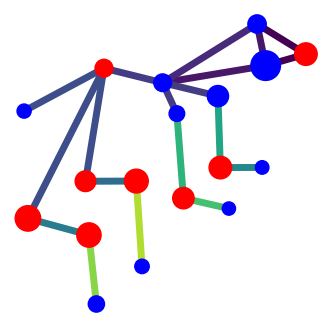

In [47]:
def center_embedding(n):
    """
    Generates a matrix ``Gamma`` that maps from a (n-1)-dimensional
    vector space  to the space of k-tuples with zero mean

    Parameters
    ----------
    n : int
        Number of keypoints.

    Returns
    -------
    Gamma: jax array of shape (n, n - 1)
        Matrix to map to centered embedded space.
    """
    X = np.tril(np.ones((n, n)), k=-1)[1:]
    X = np.eye(n)[1:] - X / X.sum(1)[:, None]
    X = X / np.sqrt((X**2).sum(1))[:, None]
    return X.T
Gamma = np.array(center_embedding(len(state_name)))

ymean = Gamma @ pca.mean_.reshape(len(state_name)-1, -1)
ymean[state_name.index('HeadB'), 2] -= 10
ymean[state_name.index('HeadF'), 0] += 10
ymean[state_name.index('SpineL'), 2] += 20
ymean[state_name.index('ShoulderL'), 0] += 20
ymean[state_name.index('ElbowL'), 0] += 20
ymean[state_name.index('ElbowL'), 2] += 10
ymean[state_name.index('ArmL'), 0] += 30
ymean[state_name.index('ArmL'), 2] += 10
ymean[state_name.index('ArmR'), 0] += 10
ymean[state_name.index('HipL'), 2] += 10
ymean[state_name.index('HipL'), 0] += 30
ymean[state_name.index('KneeL'), 2] += 10
ymean[state_name.index('KneeL'), 0] += 30
ymean[state_name.index('ShinL'), 2] += 10
ymean[state_name.index('ShinL'), 0] += 30
ymean[state_name.index('HipR'), 0] -= 10
ymean[state_name.index('HipR'), 2] += 10
fig, axes = plt.subplots(1, 1, figsize=(4, 4))
dims = [0, 2]
dims, name = [0,2], 'xz'
cmap = plt.cm.get_cmap('viridis')
keypoint_colors = cmap(np.linspace(0, 1, len(state_name)))
# print(keypoint_colors)
n_bodyparts = len(state_name)
ig_matrix_agg_xyz = np.load('./figure/rat7m/spedersac/dim64_sa_sp_buffer_20body_normalzied_lasso1e-2_xyz_group/0/ig_matrix_agg.npy')
for e in edges:
    axes.plot(
        *ymean[:, dims][e,:].T,
        color=keypoint_colors[e[0]],
        linewidth=5.0,
        zorder=0)
node_colors = ['blue' if ig_matrix_agg_xyz[0, j] < 0 else 'red' for j in range(2*n_bodyparts)]
axes.scatter(
        *ymean[:, dims].T,
        c=node_colors[:n_bodyparts],
        s=np.abs(ig_matrix_agg_xyz[0, :n_bodyparts])*120,
        zorder=1)
axes.axis('off')
plt.show()

In [48]:
np.save('ymean.npy', ymean)